In [1]:
from astropy.io import fits
from astropy.stats import biweight_midvariance as bwmv
from astropy.stats import median_absolute_deviation as mad
import astroalign as aa
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from skimage.feature import peak_local_max
# Shift the image
from scipy.ndimage import shift
from scipy.spatial import KDTree
import pandas as pd
import os


def fitsread(f, header=False):
    with fits.open(f) as hdul:
        data = hdul[0].data
        if header:
            h = hdul[0].header
            return data, h
        else:
            return data
        
def rescale(image, mref, sref, roi=None):
    imageV = image if roi is None else image[roi]
    m1 = np.median(imageV)
    s1 = mad(imageV)
    ki = sref/s1
    rimage = ki*(image - m1) + mref
    return rimage

In [2]:
def find_sources(img, detection_sigma=5, min_area=5):
    "Return sources (x, y) sorted by brightness."

    import sep

    if isinstance(img, np.ma.MaskedArray):
        image = img.filled(fill_value=_np.median(img)).astype("float32")
    else:
        image = img.astype("float32")
        
    # Interpolate a background surface
    bkg = sep.Background(image)
    thresh = detection_sigma * bkg.globalrms
    # Subtract image background and detect maximum brightness within sliding sub-windows. 
    sources = sep.extract(image - bkg.back(), thresh, minarea=min_area)
    # Sort the brightness levels and return the coordinates of the sorted maximum-brightness points
    sources.sort(order="flux")
    return np.array([[asrc["x"], asrc["y"]] for asrc in sources[::-1]])

In [3]:
# Lights
Hlights_dir = Path(os.environ['DATA'], 'DDS/Taka/Lights/IC_1805/H/Calibrated')
Hf = sorted(Hlights_dir.rglob('cal*.fits'))[0:2]
Hf

[WindowsPath('C:/Data/DDS/Taka/Lights/IC_1805/H/Calibrated/cal.H_IC 1805_600s.06002.fits'),
 WindowsPath('C:/Data/DDS/Taka/Lights/IC_1805/H/Calibrated/cal.H_IC 1805_600s.06003.fits')]

In [4]:
HLights = np.array([fitsread(f) for f in Hf])
HLights = (HLights - np.median(HLights))/HLights.std()
reference = HLights[0]
image = HLights[1]
image.mean(), np.median(image), image.std()

(0.004749665, -0.0042323847, 0.9903712)

### Star detection
- Subtract image background and detect maximum brightness within sliding sub-windows. 
- Sort the brightness levels and return the coordinates of the sorted maximum-brightness points
- Implementation of "source detection" detailed here: http://articles.adsabs.harvard.edu/pdf/1996A%26AS..117..393B

In [5]:
sources = find_sources(image, min_area=5)

-0.2783070862293243 0.42910924181342125


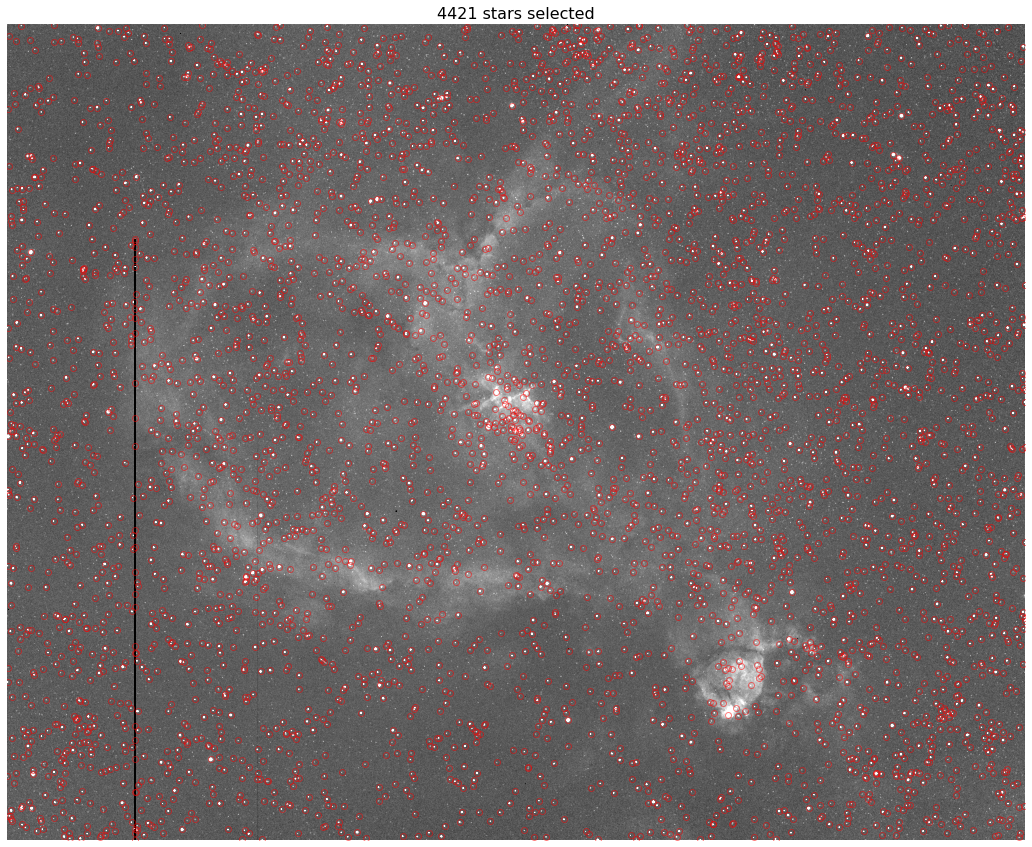

In [7]:
vmin = np.percentile(image, 0.1)
vmax = np.percentile(image, 99.5)
print(vmin, vmax)
plt.figure(figsize=(20,15));
plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray');
plt.axis('off')
plt.plot(sources[:,0], sources[:,1], 'ro', markerfacecolor='none', alpha=0.5);
plt.title(f'{len(sources)} stars selected', fontsize=16);
#plt.plot(peaks[:,1], peaks[:,0], 'cd', markerfacecolor='none', alpha=1)

Get 5 nearest neighbours for each star

In [8]:
""" Get 5 nearest star for each star (including the reference star itself,i.e. 4 other stars) """
knn = 5
coordtree = KDTree(sources)
for asrc in sources[0:1]:
    __, indx = coordtree.query(asrc, knn)
print(indx)

[   0 2306   12 1463 3715]


Zoom in a small area around some selected star and its 4 nearest neighbours

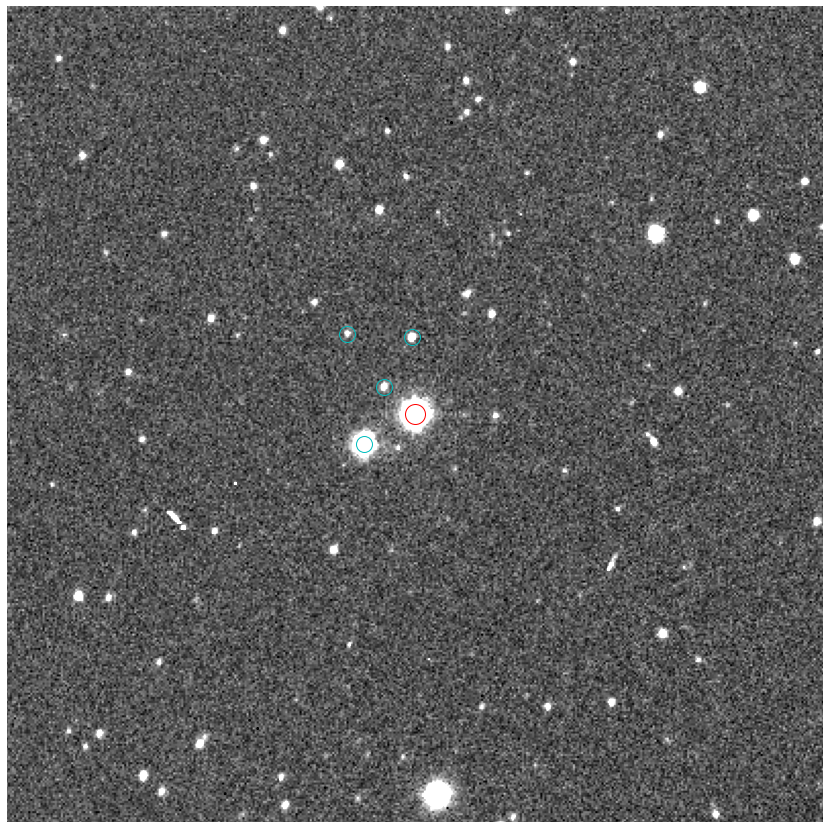

In [10]:
vmin = np.percentile(image, 0.1)
vmax = np.percentile(image, 99.5)
plt.figure(figsize=(20,15));
plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray');
plt.axis('off');
plt.plot(sources[0,0], sources[0,1], 'ro', ms=20, markerfacecolor='none');
for s in sources[indx[1:]]:
    plt.plot(s[0], s[1], 'co', ms=16, markerfacecolor='none');
plt.axis([sources[0,0]-200, sources[0,0]+200, sources[0,1]-200, sources[0,1]+200]);

In [14]:
""" Get 5 nearest star for each star (including the reference star itself, so there are 4 other stars) """
knn = 5
for asrc in sources[0:1]:
    __, indx = coordtree.query(asrc, knn)

In [15]:
indx

array([   0, 2306,   12, 1463, 3715])

In [16]:
from itertools import combinations
from collections import Counter

Generate all possible triangles with the 5 indx provided

In [17]:
cmbs = list(combinations(indx, 3))
cmbs

[(0, 2306, 12),
 (0, 2306, 1463),
 (0, 2306, 3715),
 (0, 12, 1463),
 (0, 12, 3715),
 (0, 1463, 3715),
 (2306, 12, 1463),
 (2306, 12, 3715),
 (2306, 1463, 3715),
 (12, 1463, 3715)]

(0, 2306, 12)
triangle vertices [x y] =  [3963.07119477  593.15470759] [3947.84806796  606.46493721] [3937.87756782  578.46870978]


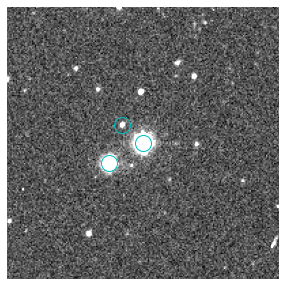

In [18]:
# _arrangetriplet(sources, vertex_indices=list(cmbs[0]))

vertex_indices=cmbs[0]
print(vertex_indices)
ind1, ind2, ind3 = vertex_indices
x1, x2, x3 = sources[list(vertex_indices)]
print('triangle vertices [x y] = ', x1, x2, x3)

plt.figure(figsize=(5,5));
plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray');
plt.axis('off');
for x in [x1, x2, x3]:
    plt.plot(x[0], x[1], 'co', ms=16, markerfacecolor='none');
plt.axis([sources[0,0]-100, sources[0,0]+100, sources[0,1]-100, sources[0,1]+100]);

In [19]:
""" Define triangle side L1, L2, L3 as lengths L1 < L2 < L3 """

side_ind = np.array([(ind1, ind2), (ind2, ind3), (ind3, ind1)])
print(side_ind)
side_lengths = list(map(np.linalg.norm, (x1 - x2, x2 - x3, x3 - x1)))

l1_ind, l2_ind, l3_ind = np.argsort(side_lengths)

[[   0 2306]
 [2306   12]
 [  12    0]]


In [20]:
""" get the 3 triangle vertices (a, b, c) such that:
    a vertex at L1, L2
    b vertex at L2, L3
    c vertex at L3, L1 """

# To define each vertex, we count how many times each vertex is present in the pairs of sides. It will be present twice if it's the 
# vertex where the 2 selected sides meet. 
count = Counter(side_ind[[l1_ind, l2_ind]].flatten())
print(count)
# Get the 1st most common occurence. That's the vertex where those two sides joined
a = count.most_common(1)[0][0]
# do the same for the other sides
count = Counter(side_ind[[l2_ind, l3_ind]].flatten())
b = count.most_common(1)[0][0]
count = Counter(side_ind[[l3_ind, l1_ind]].flatten())
c = count.most_common(1)[0][0]
print('vertex index (a) at L1,L2: ', a)
print('vertex index (b) at L2,L3: ', b)
print('vertex index (c) at L1,L3: ', c)
# Store that in an array of 3 vertices, ordered as a,b,c
triangle_vertices = np.array([a, b, c])

Counter({0: 2, 2306: 1, 12: 1})
vertex index (a) at L1,L2:  0
vertex index (b) at L2,L3:  12
vertex index (c) at L1,L3:  2306


For the triangle, we define the invariant as the ratio of their sides b/a & c/b

In [21]:
tri_inv = [side_lengths[l2_ind] / side_lengths[l1_ind], side_lengths[l3_ind] / side_lengths[l2_ind]]

In the next image, the nearest triangle will be matched and transformed to maximize correspondance. 